<a href="https://colab.research.google.com/github/ScientistLim/ProjectAW/blob/feature%2Fmodel%2Flstm-transformer/tft_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 53.1 MB/s eta 0:00:00


In [6]:
%load_ext tensorboard

In [7]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import datetime  # datetime 모듈 임포트
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pytorch_forecasting.models.temporal_fusion_transformer.sub_modules import VariableSelectionNetwork
from torch import nn
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score


In [8]:
file_path = '/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/[final] four-cycle-16months.xlsx'
df = pd.read_excel(file_path)

In [9]:
# 데이터 확인
print(df.head())

                 Time  feed_pressure
0 2023-06-16 13:30:00       9.050625
1 2023-06-16 13:40:00       9.051000
2 2023-06-16 13:50:00       9.051374
3 2023-06-16 14:00:00       9.051749
4 2023-06-16 14:10:00       9.052123


In [10]:
# 데이터 전처리: 필요한 컬럼 설정 (Time, feed_pressure)
df['time'] = pd.to_datetime(df['Time'])
df['time_idx'] = ((df['time'] - df['time'].min()).dt.total_seconds() // 60).astype(int)
df['group'] = "feed_pressure"  # 그룹화 컬럼 추가

# 데이터 길이 확인
total_length = len(df)
print(f"Total data length: {total_length} rows")

Total data length: 71488 rows


### 데이터 준비 및 설정
우선 max_encoder_length와 max_prediction_length를 설정하여 데이터의 인코더 및 예측 길이를 정의합니다.

In [11]:
# max_encoder_length와 max_prediction_length 설정
max_encoder_length = 2000 #26808 #6개월
max_prediction_length = 400 #4468 #1개월
min_encoder_length = 500 #10000

print(f"Max encoder length: {max_encoder_length} entries")
print(f"Max prediction length: {max_prediction_length} entries")
print(f"Min_encoder_length: {min_encoder_length} entries")

Max encoder length: 2000 entries
Max prediction length: 400 entries
Min_encoder_length: 500 entries


In [12]:
# 전체 데이터를 4개의 반복 패턴으로 나누기 (16주씩 4번 반복)
cycle_length = len(df) // 4

# 각 패턴을 데이터셋으로 나누기
train_data = pd.concat([df.iloc[:cycle_length * 3]])  # 처음 3개의 반복 패턴을 훈련 데이터로 사용
val_data = df.iloc[cycle_length * 3:]  # 마지막 반복 패턴을 검증 데이터로 사용

### TimeSeriesDataSet 생성
TimeSeriesDataSet을 사용해 데이터를 생성합니다. 여기에는 타겟, 그룹화 방식, 그리고 변동하는 시계열 컬럼을 정의합니다.


In [13]:
normalizer = GroupNormalizer(groups=["group"], transformation="softplus")

# 학습용 및 검증용 TimeSeriesDataSet 생성
training = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=min_encoder_length,
    time_varying_unknown_reals=["feed_pressure"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=normalizer,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet(
    val_data,
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=min_encoder_length,
    time_varying_unknown_reals=["feed_pressure"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=normalizer,
    allow_missing_timesteps=True
)

# normalizer 매개변수 출력
normalizer_stats = normalizer.get_parameters(groups=df["group"])
print(f"Normalizer parameters (mean, std): {normalizer_stats}")

Normalizer parameters (mean, std): [13.74567639  2.36048209]


### DataLoader 생성
DataLoader를 생성하여 모델이 데이터를 학습할 수 있도록 준비합니다.

In [14]:
# DataLoader 생성
batch_size = 8
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, shuffle=False, num_workers=4)

# Validation DataLoader 생성
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

### Temporal Fusion Transformer 모델 생성
Temporal Fusion Transformer 모델을 생성하여 데이터셋을 학습할 준비를 합니다.

In [15]:
# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001, # 학습률
    hidden_size=16, #모델의 잠재 표현 크기
    attention_head_size=1,  # 어텐션 헤드 개수(패턴 포착)
    dropout=0.1,  # 과적합 방지
    hidden_continuous_size=16,  # 연속형 변수의 임베딩 크기
    loss=MAE(),
    log_interval=10, # 학습 로그 출력하는 빈도
    reduce_on_plateau_patience=3, # 손실이 개선되지 않을 시 학습률 줄이는 시점
    optimizer="adam"
)

# 모델의 모든 파라미터를 GPU로 이동
tft = tft.to('cuda:0')

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [16]:
def get_attention_mask(self, encoder_lengths, decoder_lengths):
    # 디버깅 코드 추가
    print(f"encoder_lengths device: {encoder_lengths.device}")
    print(f"decoder_lengths device: {decoder_lengths.device}")

    encoder_mask = create_mask(encoder_lengths.max(), encoder_lengths).unsqueeze(1).expand(-1, decoder_lengths.max(), -1)

    # 디버깅 코드 추가
    print(f"encoder_mask device: {encoder_mask.device}")

    try:
        # combine masks along attended time - first encoder and then decoder
        mask = torch.cat(
            (
                encoder_mask,
                create_mask(decoder_lengths.max(), decoder_lengths).unsqueeze(2).expand(-1, -1, encoder_lengths.max()),
            ),
            dim=1,
        )
    except RuntimeError as e:
        print(f"RuntimeError: {e}")
        raise e

    return mask

In [17]:
def on_after_batch_transfer(self, batch, dataloader_idx):
    """
    데이터 배치가 모델로 전달되기 전에 모든 배치를 GPU로 이동.
    """
    device = self.device
    features, targets = batch

    # features와 targets를 재귀적으로 GPU로 이동
    features = move_to_device(features, device)
    targets = move_to_device(targets, device)

    # 모델도 GPU로 이동
    self.tft_model = self.tft_model.to(device)

    return features, targets


### LightningModule 정의 및 Trainer 설정
PyTorch Lightning을 이용하여 모델 학습을 보다 쉽게 관리할 수 있도록 합니다.


In [18]:
class TFTLightningModule(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

        # 하이퍼파라미터 저장 시 'tft_model'을 무시하도록 설정
        self.save_hyperparameters(ignore=['tft_model', 'loss', 'logging_metrics'])

    def forward(self, x):
        # 입력 데이터를 모델이 있는 장치로 이동
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        # 모델이 있는 장치 확인
        device = self.device

        # 필요한 시점에 GPU로 이동
        features, targets = batch
        features = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in features.items()}
        targets = targets.to(device)

        # Forward pass 및 손실 계산
        y_hat = self(features)
        loss = self.tft_model.loss(y_hat["prediction"], targets)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # 모델이 있는 장치 확인
        device = self.device

        # 필요한 시점에 GPU로 이동
        features, targets = batch
        features = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in features.items()}
        targets = targets.to(device)

        # Forward pass 및 손실 계산
        y_hat = self(features)
        loss = self.tft_model.loss(y_hat["prediction"], targets)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        # 옵티마이저 정의
        optimizer = torch.optim.Adam(self.tft_model.parameters(), lr=0.001, weight_decay=1e-5)

        # ReduceLROnPlateau 스케줄러 정의
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

        # PyTorch Lightning에 사용할 스케줄러와 모니터링할 대상 설정
        scheduler_config = {
            'scheduler': scheduler,
            'monitor': 'val_loss',  # 학습률 조정을 위해 모니터링할 지표
            'interval': 'epoch',    # 스케줄러 업데이트 간격 ('epoch'마다 적용)
            'frequency': 1          # 스케줄러 적용 빈도 (매 에폭마다 적용)
        }

        # 옵티마이저와 스케줄러를 함께 반환
        return [optimizer], [scheduler_config]

    # on_after_batch_transfer 제거: 데이터 배치를 미리 GPU로 이동하지 않음


## 모델 학습

In [19]:
# Google Drive에 체크포인트 저장 경로 설정
local_checkpoint_dir = "/content/checkpoints/"
drive_checkpoint_dir = "/content/drive/MyDrive/종설프1_5팀/checkpoints/"
os.makedirs(local_checkpoint_dir, exist_ok=True)
os.makedirs(drive_checkpoint_dir, exist_ok=True)

# 기존 체크포인트 파일 삭제 함수
def delete_existing_checkpoints(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        for filename in os.listdir(checkpoint_dir):
            file_path = os.path.join(checkpoint_dir, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    print(f"Deleted checkpoint file: {file_path}")
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")

In [20]:
from pytorch_lightning import Trainer

# TFT 모델을 LightningModule로 감싸기
tft_module = TFTLightningModule(tft)

# 학습을 위한 EarlyStopping 설정
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, min_delta=1e-4)


# 체크포인트 설정
checkpoint_callback = ModelCheckpoint(
    dirpath=local_checkpoint_dir,
    filename="tft-best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

# Trainer 설정
trainer = Trainer(
    max_epochs=20,
    accelerator="auto",
    devices=1,
    gradient_clip_val=0.3,  # 그래디언트 클리핑 값 조절
    callbacks=[early_stop_callback, checkpoint_callback],
    accumulate_grad_batches=4,
    precision="16-mixed"  # Mixed Precision Training 사용
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<span style="color:red;">주의: 체크포인트 삭제!</span>

In [ ]:
# 학습 시작 전에 기존 체크포인트 삭제 여부를 결정하는 코드 블록
delete_checkpoints = input("기존 체크포인트 파일을 삭제하시겠습니까? (y/n): ").lower()
if delete_checkpoints == 'y':
    print("기존 체크포인트 파일을 삭제합니다.")
    delete_existing_checkpoints(local_checkpoint_dir)
    delete_existing_checkpoints(drive_checkpoint_dir)
else:
    print("기존 체크포인트 파일을 유지합니다.")

기존 체크포인트 파일을 삭제하시겠습니까? (y/n): ㅛ
기존 체크포인트 파일을 유지합니다.


In [21]:
import shutil

# 체크포인트 경로 설정
best_checkpoint_path = os.path.join(local_checkpoint_dir, "tft-best-checkpoint.ckpt")

# 이전 체크포인트가 있으면 로드
if os.path.exists(best_checkpoint_path):
    print("이전 체크포인트에서 학습을 이어갑니다.")
    trainer.fit(tft_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, ckpt_path=best_checkpoint_path)
else:
    print("새로 학습을 시작합니다.")
    trainer.fit(tft_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

# 학습이 끝난 후 Google Drive로 체크포인트 파일 복사
if os.path.exists(best_checkpoint_path):
    shutil.copy(best_checkpoint_path, drive_checkpoint_dir)
    print(f"Best checkpoint file copied to Google Drive: {drive_checkpoint_dir}")
else:
    print("No checkpoint file found.")

새로 학습을 시작합니다.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


AttributeError: 'ReduceLROnPlateau' object has no attribute 'optimizer'

## 모델 다시 로드

In [ ]:
# Google Drive에 저장된 체크포인트 경로 설정
checkpoint_dir = "/content/drive/MyDrive/종설프1_5팀/checkpoints/"
checkpoint_path = os.path.join(checkpoint_dir, "tft-best-checkpoint.ckpt")

# 저장된 체크포인트로부터 모델 로드
if os.path.exists(checkpoint_path):
    print("저장된 체크포인트에서 모델을 로드합니다.")
    tft_module = TFTLightningModule.load_from_checkpoint(checkpoint_path, tft_model=tft)
    tft_module.eval()  # 모델을 평가 모드로 전환
else:
    raise FileNotFoundError("체크포인트 파일을 찾을 수 없습니다.")

NameError: name 'os' is not defined

## 예측

In [ ]:
# 기존 데이터의 처음 4주치 데이터만 가져오기
num_rows_4_weeks = len(df) // 16  # 전체 데이터의 1/16만큼 가져옴
encoder_data = df.iloc[:num_rows_4_weeks]
encoder_data_length = len(encoder_data)
print(f"encoder data length: {encoder_data_length} rows")

encoder data length: 4468 rows


In [ ]:
# 기존 데이터의 마지막 time 및 time_idx 확인
last_time = encoder_data["time"].max()
last_time_idx = encoder_data["time_idx"].max()

print(f"Last time in encoder data: {last_time}")
print(f"Last time_idx in encoder data: {last_time_idx}")

# 12주 예측을 위해 필요한 빈 예측 데이터 생성
new_prediction_data = pd.DataFrame({
    "time": pd.date_range(last_time + pd.Timedelta(minutes=10), periods=12 * 7 * 24 * 6, freq="10min"),
    "feed_pressure": [np.nan] * (12 * 7 * 24 * 6),  # 예측 부분은 모두 NaN으로 설정
    "time_idx": range(last_time_idx + 1, last_time_idx + 1 + 12 * 7 * 24 * 6),
    "group": ["feed_pressure"] * (12 * 7 * 24 * 6),
})

# NaN 값을 기존 데이터의 마지막 값으로 채우기 (예측용으로 대체값 설정)
new_prediction_data["feed_pressure"].fillna(encoder_data["feed_pressure"].iloc[-1], inplace=True)

# 인코더 데이터와 예측 데이터를 병합하여 최종 예측용 데이터 생성
new_data = pd.concat([encoder_data, new_prediction_data]).reset_index(drop=True)
new_data_length = len(new_data)
print(f"Total new data length for prediction: {new_data_length} rows")

Last time in encoder data: 2023-07-17 14:00:00
Last time_idx in encoder data: 44670
Total new data length for prediction: 16564 rows


<ipython-input-74-aa3bac000b56>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_prediction_data["feed_pressure"].fillna(encoder_data["feed_pressure"].iloc[-1], inplace=True)


In [ ]:
# 새로운 특성 추가
new_data["hour"] = new_data["time"].dt.hour
new_data["day_of_week"] = new_data["time"].dt.dayofweek

# 필요한 입력 특성들을 다시 확인하고 포함하기
time_varying_known_reals = ["time_idx", "hour", "day_of_week"]  # 모델에서 이미 알고 있는 입력 값
time_varying_unknown_reals = ["feed_pressure"]  # 모델이 예측해야 하는 값

# 새로운 TimeSeriesDataSet 생성 (예측용)
prediction_data = TimeSeriesDataSet(
    new_data,
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    target_normalizer=normalizer,
    allow_missing_timesteps=True
)

In [ ]:
# 예측용 DataLoader 생성
prediction_dataloader = prediction_data.to_dataloader(train=False, batch_size=64, num_workers=0)

# 모델을 CUDA로 이동 (필요한 경우)
tft_module = tft_module.cuda() if torch.cuda.is_available() else tft_module

# 예측 수행
predictions = []
for batch in prediction_dataloader:
    # TimeSeriesDataSet에서는 (inputs, targets) 형태로 반환되며 예측에서는 targets가 None
    x, _ = batch
    x = {key: val.cuda() if torch.cuda.is_available() else val for key, val in x.items()}

    # 모델 예측
    with torch.no_grad():
        output = tft_module(x)
        prediction = output["prediction"].cpu().numpy().squeeze()

        # 예측 값 저장
        predictions.append(prediction)

In [ ]:
# 리스트를 배열로 변환하기 전에 모든 예측의 차원을 확인하고 맞추기
for idx, pred in enumerate(predictions):
    if pred.ndim == 1:  # 마지막 배치의 경우 (200,) 형태로 되어 있음
        predictions[idx] = np.expand_dims(pred, axis=0)  # 차원을 (1, 200)으로 확장

# 리스트를 배열로 변환
predictions = np.concatenate(predictions, axis=0)

In [ ]:
# 예측 데이터의 일부를 선택해서 실제 데이터와 비교 (예를 들어, 첫 번째 100개 시퀀스만 사용)
selected_predictions = predictions[:100]  # 첫 번째 100개 시퀀스 선택
required_length = selected_predictions.shape[0] * selected_predictions.shape[1]  # 필요 데이터 길이 계산

# 실제 데이터도 필요한 길이만큼 선택
actual_data_16 = df.iloc[num_rows_4_weeks:num_rows_4_weeks + required_length]
actuals = actual_data_16["feed_pressure"].values.reshape(selected_predictions.shape[0], selected_predictions.shape[1])

# 선택된 실제 데이터와 예측 데이터의 형태 확인
print(f"Shape of actuals: {actuals.shape}")
print(f"Shape of selected_predictions: {selected_predictions.shape}")

# 평가 지표 계산
rmse = mean_squared_error(actuals, selected_predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, selected_predictions) * 100
r2 = r2_score(actuals, selected_predictions)

# 평가 지표 출력
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R²: {r2}")


Shape of actuals: (100, 200)
Shape of selected_predictions: (100, 200)
RMSE: 4.444095177799543
MAPE: 31.93466587869118%
R²: -2.7930683646622323


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


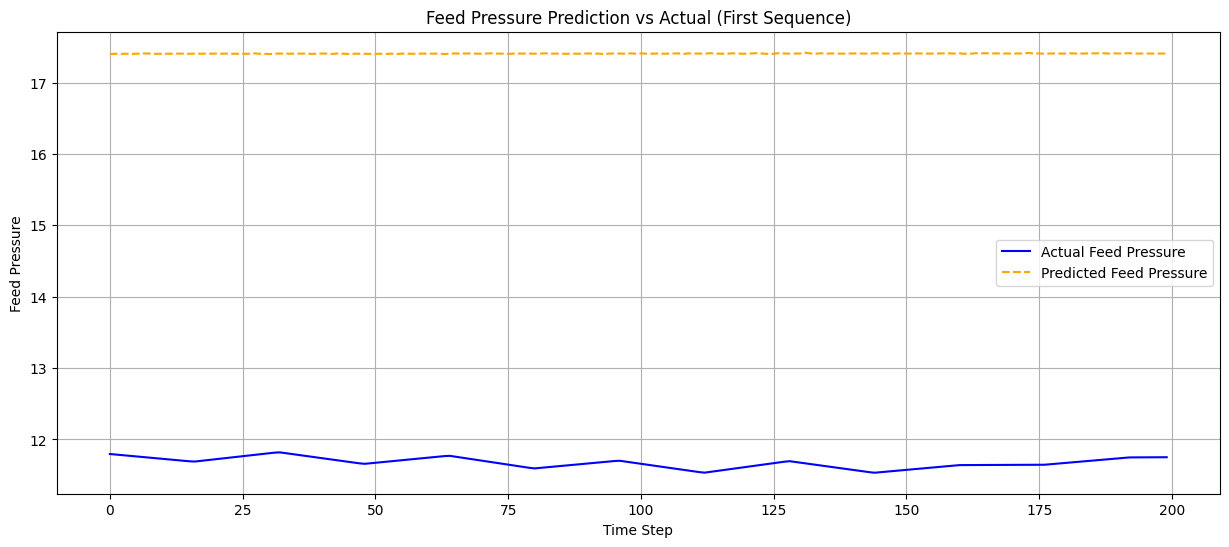

In [ ]:
import matplotlib.pyplot as plt

# 예측과 실제 값을 비교하는 그래프 생성
plt.figure(figsize=(15, 6))

# 선택된 예측 값과 실제 값 중 첫 번째 시퀀스(시각적으로 잘 보이기 위해 첫 시퀀스만 표시)
time_axis = range(len(selected_predictions[0]))

plt.plot(time_axis, actuals[0], label="Actual Feed Pressure", color="blue", linewidth=1.5)
plt.plot(time_axis, selected_predictions[0], label="Predicted Feed Pressure", color="orange", linewidth=1.5, linestyle="--")

plt.xlabel("Time Step")
plt.ylabel("Feed Pressure")
plt.title("Feed Pressure Prediction vs Actual (First Sequence)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# CSV 파일 불러오기
file_path = '/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/2차 통합운전데이터.csv'



Initial Data:
               Time  feed_pressure                time  time_idx  \
0  2024/10/07 16:40       9.050625 2024-10-07 16:40:00         0   
1  2024/10/07 16:50       9.050625 2024-10-07 16:50:00         1   
2  2024/10/07 17:00       9.074375 2024-10-07 17:00:00         2   
3  2024/10/07 17:10       9.086250 2024-10-07 17:10:00         3   
4  2024/10/07 17:20       9.104250 2024-10-07 17:20:00         4   

           group  
0  feed_pressure  
1  feed_pressure  
2  feed_pressure  
3  feed_pressure  
4  feed_pressure  
Initial data length: 223 rows
Adjusted max_encoder_length: 213
Adjusted max_prediction_length: 1
TimeSeriesDataSet 생성 성공
Shape of actuals: (1, 10)
Shape of selected_predictions: (1, 10)
RMSE: 7.247150389099121
MAPE: 72.35053468439261%
R²: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


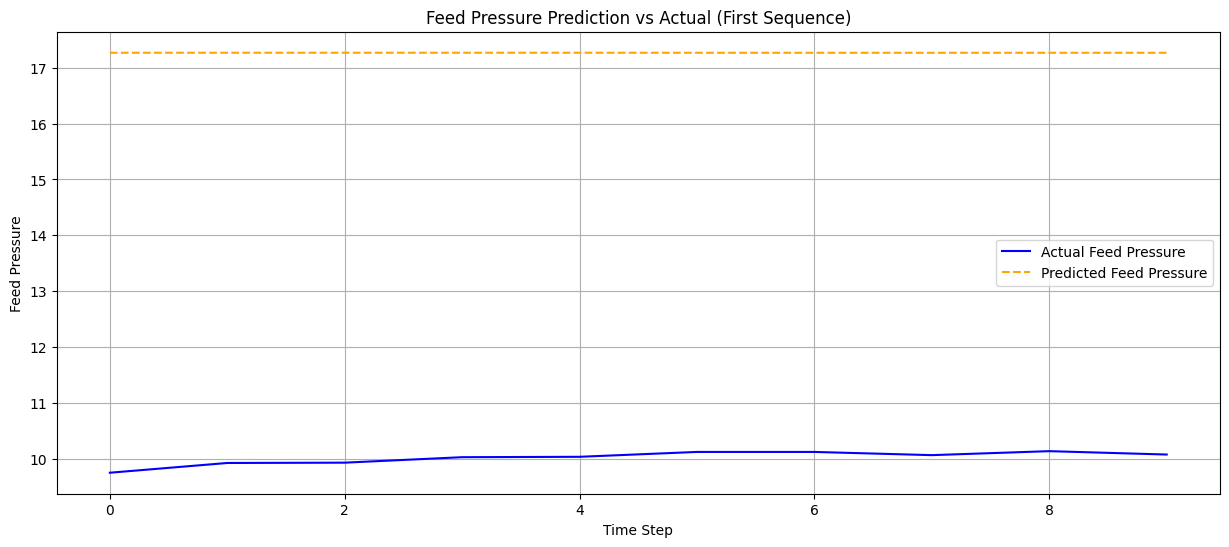

In [ ]:
# 인코딩 형식을 'euc-kr' 또는 'cp949'로 설정
df2 = pd.read_csv(file_path)

# 데이터 전처리: 필요한 컬럼 설정 (Time, feed_pressure)
df2['time'] = pd.to_datetime(df2['Time'])
df2['time_idx'] = ((df2['time'] - df2['time'].min()).dt.total_seconds() // 600).astype(int)
df2['group'] = "feed_pressure"  # 그룹화 컬럼 추가

# 데이터 분할: 앞 20%는 초기 입력, 나머지 80%는 예측용 데이터
test_data_length = len(df2)
initial_data_length = int(test_data_length * 0.2)
initial_data = df2.iloc[:initial_data_length].copy()
remaining_data = df2.iloc[initial_data_length:].copy()

# 초기 입력 데이터 출력
print("Initial Data:")
print(initial_data.head())

# 데이터 준비
initial_data_length = len(initial_data)
print(f"Initial data length: {initial_data_length} rows")

# 새로운 특성 추가
initial_data.loc[:, "hour"] = initial_data["time"].dt.hour
initial_data.loc[:, "day_of_week"] = initial_data["time"].dt.dayofweek

# 필요한 입력 특성들을 다시 확인하고 포함하기
time_varying_known_reals = ["time_idx", "hour", "day_of_week"]  # 모델에서 이미 알고 있는 입력 값
time_varying_unknown_reals = ["feed_pressure"]  # 모델이 예측해야 하는 값

# max_encoder_length와 max_prediction_length가 데이터의 길이에 적합한지 확인하고 조정
min_required_length = 10  # 최소한으로 필요한 데이터 길이 설정
if max_encoder_length >= initial_data_length - min_required_length:
    max_encoder_length = initial_data_length - min_required_length
if max_prediction_length >= initial_data_length - max_encoder_length - min_required_length:
    max_prediction_length = max(1, initial_data_length - max_encoder_length - min_required_length)

# 현재 설정된 max_encoder_length와 max_prediction_length 출력
print(f"Adjusted max_encoder_length: {max_encoder_length}")
print(f"Adjusted max_prediction_length: {max_prediction_length}")

# TimeSeriesDataSet 생성 (검증용)
try:
    validation_data = TimeSeriesDataSet(
        initial_data,
        time_idx="time_idx",
        target="feed_pressure",
        group_ids=["group"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=normalizer,
        allow_missing_timesteps=True
    )
    print("TimeSeriesDataSet 생성 성공")
except AssertionError as e:
    print("TimeSeriesDataSet 생성 실패: ", e)
    print("initial_data_length: ", initial_data_length)
    print("max_encoder_length: ", max_encoder_length)
    print("max_prediction_length: ", max_prediction_length)

# 검증용 DataLoader 생성
if 'validation_data' in locals():
    validation_dataloader = validation_data.to_dataloader(train=False, batch_size=64, num_workers=0)

    # 모델을 CUDA로 이동 (필요한 경우)
    tft_module = tft_module.cuda() if torch.cuda.is_available() else tft_module

    # 예측 수행
    predictions = []
    for batch in validation_dataloader:
        # TimeSeriesDataSet에서는 (inputs, targets) 형태로 반환되며 예측에서는 targets가 None
        x, _ = batch
        x = {key: val.cuda() if torch.cuda.is_available() else val for key, val in x.items()}

        # 모델 예측
        with torch.no_grad():
            output = tft_module(x)
            prediction = output["prediction"].cpu().numpy().squeeze()

            # 예측 값 저장
            predictions.append(prediction)

    # 리스트를 배열로 변환하기 전에 모든 예측의 차원을 확인하고 맞추기
    for idx, pred in enumerate(predictions):
        if pred.ndim == 1:  # 마지막 배치의 경우 (200,) 형태로 되어 있음
            predictions[idx] = np.expand_dims(pred, axis=0)  # 차원을 (1, 200)으로 확장

    # 리스트를 배열로 변환
    predictions = np.concatenate(predictions, axis=0)

    # 예측 데이터의 일부를 선택해서 실제 데이터와 비교 (예를 들어, 첫 번째 100개 시퀀스만 사용)
    selected_predictions = predictions[:100]  # 첫 번째 100개 시퀀스 선택
    required_length = selected_predictions.shape[0] * selected_predictions.shape[1]  # 필요 데이터 길이 계산

    # 실제 데이터도 필요한 길이만큼 선택
    actual_data = remaining_data.iloc[:required_length]
    actuals = actual_data["feed_pressure"].values.reshape(selected_predictions.shape[0], selected_predictions.shape[1])

    # 선택된 실제 데이터와 예측 데이터의 형태 확인
    print(f"Shape of actuals: {actuals.shape}")
    print(f"Shape of selected_predictions: {selected_predictions.shape}")

    # 평가 지표 계산
    rmse = mean_squared_error(actuals, selected_predictions, squared=False)
    mape = mean_absolute_percentage_error(actuals, selected_predictions) * 100
    r2 = r2_score(actuals, selected_predictions)

    # 평가 지표 출력
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}%")
    print(f"R²: {r2}")

    import matplotlib.pyplot as plt

    # 예측과 실제 값을 비교하는 그래프 생성
    plt.figure(figsize=(15, 6))

    # 선택된 예측 값과 실제 값 중 첫 번째 시퀀스(시각적으로 잘 보이기 위해 첫 시퀀스만 표시)
    time_axis = range(len(selected_predictions[0]))

    plt.plot(time_axis, actuals[0], label="Actual Feed Pressure", color="blue", linewidth=1.5)
    plt.plot(time_axis, selected_predictions[0], label="Predicted Feed Pressure", color="orange", linewidth=1.5, linestyle="--")

    plt.xlabel("Time Step")
    plt.ylabel("Feed Pressure")
    plt.title("Feed Pressure Prediction vs Actual (First Sequence)")
    plt.legend()
    plt.grid(True)
    plt.show()


Initial Data:
               Time  feed_pressure                time  time_idx  \
0  2024/10/07 16:40       9.050625 2024-10-07 16:40:00         0   
1  2024/10/07 16:50       9.050625 2024-10-07 16:50:00         1   
2  2024/10/07 17:00       9.074375 2024-10-07 17:00:00         2   
3  2024/10/07 17:10       9.086250 2024-10-07 17:10:00         3   
4  2024/10/07 17:20       9.104250 2024-10-07 17:20:00         4   

           group  
0  feed_pressure  
1  feed_pressure  
2  feed_pressure  
3  feed_pressure  
4  feed_pressure  
Initial data length: 223 rows
Adjusted max_encoder_length: 213
Adjusted max_prediction_length: 1
TimeSeriesDataSet 생성 성공
Shape of actuals: (1, 10)
Shape of selected_predictions: (1, 10)
RMSE: 3.5841367401123043
MAPE: 35.786817334740654%
R²: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


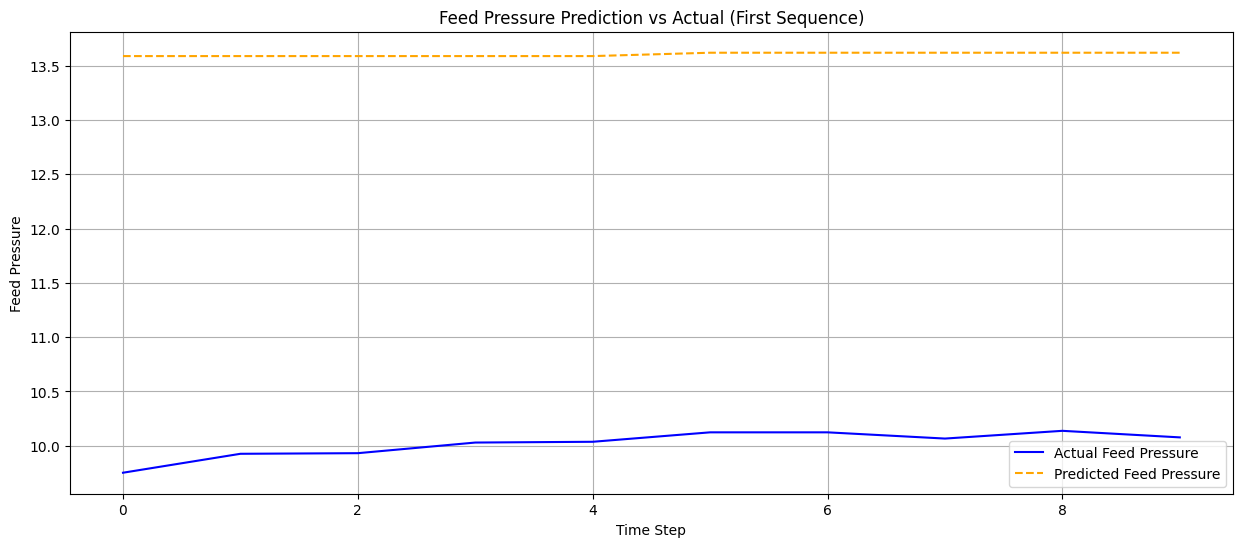

In [ ]:


# 인코딩 형식을 'euc-kr' 또는 'cp949'로 설정
df2 = pd.read_csv(file_path)

# 데이터 전처리: 필요한 컬럼 설정 (Time, feed_pressure)
df2['time'] = pd.to_datetime(df2['Time'])
df2['time_idx'] = ((df2['time'] - df2['time'].min()).dt.total_seconds() // 600).astype(int)
df2['group'] = "feed_pressure"  # 그룹화 컬럼 추가

# 데이터 분할: 앞 20%는 초기 입력, 나머지 80%는 예측용 데이터
test_data_length = len(df2)
initial_data_length = int(test_data_length * 0.2)
initial_data = df2.iloc[:initial_data_length].copy()
remaining_data = df2.iloc[initial_data_length:].copy()

# 초기 입력 데이터 출력
print("Initial Data:")
print(initial_data.head())

# 데이터 준비
initial_data_length = len(initial_data)
print(f"Initial data length: {initial_data_length} rows")

# 새로운 특성 추가
initial_data.loc[:, "hour"] = initial_data["time"].dt.hour
initial_data.loc[:, "day_of_week"] = initial_data["time"].dt.dayofweek

# 필요한 입력 특성들을 다시 확인하고 포함하기
time_varying_known_reals = ["time_idx", "hour", "day_of_week"]  # 모델에서 이미 알고 있는 입력 값
time_varying_unknown_reals = ["feed_pressure"]  # 모델이 예측해야 하는 값

# max_encoder_length와 max_prediction_length가 데이터의 길이에 적합한지 확인하고 조정
min_required_length = 10  # 최소한으로 필요한 데이터 길이 설정
if max_encoder_length >= initial_data_length - min_required_length:
    max_encoder_length = initial_data_length - min_required_length
if max_prediction_length >= initial_data_length - max_encoder_length - min_required_length:
    max_prediction_length = max(1, initial_data_length - max_encoder_length - min_required_length)

# 현재 설정된 max_encoder_length와 max_prediction_length 출력
print(f"Adjusted max_encoder_length: {max_encoder_length}")
print(f"Adjusted max_prediction_length: {max_prediction_length}")

# TimeSeriesDataSet 생성 (검증용)
try:
    validation_data = TimeSeriesDataSet(
        initial_data,
        time_idx="time_idx",
        target="feed_pressure",
        group_ids=["group"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=normalizer,
        allow_missing_timesteps=True
    )
    print("TimeSeriesDataSet 생성 성공")
except AssertionError as e:
    print("TimeSeriesDataSet 생성 실패: ", e)
    print("initial_data_length: ", initial_data_length)
    print("max_encoder_length: ", max_encoder_length)
    print("max_prediction_length: ", max_prediction_length)

# 검증용 DataLoader 생성
if 'validation_data' in locals():
    validation_dataloader = validation_data.to_dataloader(train=False, batch_size=64, num_workers=0)

    # 모델을 CUDA로 이동 (필요한 경우)
    tft_module = tft_module.cuda() if torch.cuda.is_available() else tft_module

    # 예측 수행
    predictions = []
    for batch in validation_dataloader:
        # TimeSeriesDataSet에서는 (inputs, targets) 형태로 반환되며 예측에서는 targets가 None
        x, _ = batch
        x = {key: val.cuda() if torch.cuda.is_available() else val for key, val in x.items()}

        # 모델 예측
        with torch.no_grad():
            output = tft_module(x)
            prediction = output["prediction"].cpu().numpy().squeeze()

            # 예측 값 저장
            predictions.append(prediction)

    # 리스트를 배열로 변환하기 전에 모든 예측의 차원을 확인하고 맞추기
    for idx, pred in enumerate(predictions):
        if pred.ndim == 1:  # 마지막 배치의 경우 (200,) 형태로 되어 있음
            predictions[idx] = np.expand_dims(pred, axis=0)  # 차원을 (1, 200)으로 확장

    # 리스트를 배열로 변환
    predictions = np.concatenate(predictions, axis=0)

    # 예측 데이터의 일부를 선택해서 실제 데이터와 비교 (예를 들어, 첫 번째 10개 시퀀스만 사용)
    selected_predictions = predictions[:10]  # 첫 번째 10개 시퀀스 선택
    required_length = selected_predictions.shape[0] * selected_predictions.shape[1]  # 필요 데이터 길이 계산

    # 실제 데이터도 필요한 길이만큼 선택
    actual_data = remaining_data.iloc[:required_length]
    actuals = actual_data["feed_pressure"].values.reshape(selected_predictions.shape[0], selected_predictions.shape[1])

    # 선택된 실제 데이터와 예측 데이터의 형태 확인
    print(f"Shape of actuals: {actuals.shape}")
    print(f"Shape of selected_predictions: {selected_predictions.shape}")

    # 평가 지표 계산
    rmse = mean_squared_error(actuals, selected_predictions, squared=False)
    mape = mean_absolute_percentage_error(actuals, selected_predictions) * 100
    r2 = r2_score(actuals, selected_predictions)

    # 평가 지표 출력
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}%")
    print(f"R²: {r2}")

    import matplotlib.pyplot as plt

    # 예측과 실제 값을 비교하는 그래프 생성
    plt.figure(figsize=(15, 6))

    # 선택된 예측 값과 실제 값 중 첫 번째 시퀀스(시각적으로 잘 보이기 위해 첫 시퀀스만 표시)
    time_axis = range(len(selected_predictions[0]))

    plt.plot(time_axis, actuals[0], label="Actual Feed Pressure", color="blue", linewidth=1.5)
    plt.plot(time_axis, selected_predictions[0], label="Predicted Feed Pressure", color="orange", linewidth=1.5, linestyle="--")

    plt.xlabel("Time Step")
    plt.ylabel("Feed Pressure")
    plt.title("Feed Pressure Prediction vs Actual (First Sequence)")
    plt.legend()
    plt.grid(True)
    plt.show()